In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import matplotlib.pyplot as plt

In [2]:
RF = pd.read_parquet("Data/agg_table_new_zones8Bot.parquet")
pivot_df = RF.pivot(index='time_bin', columns='h3_index', values='order_count').fillna(0) #we need H3 indeces to map with ABM

In [ ]:
# Get time features
pivot_df = pivot_df.reset_index()
pivot_df['hour'] = pivot_df['time_bin'].dt.hour
pivot_df['dayofweek'] = pivot_df['time_bin'].dt.dayofweek  # 0=Montag, ..., 6=Sonntag

# Cylcical features (like a clock)
pivot_df['hour_sin'] = np.sin(2 * np.pi * pivot_df['hour'] / 24)
pivot_df['hour_cos'] = np.cos(2 * np.pi * pivot_df['hour'] / 24)
pivot_df['day_sin'] = np.sin(2 * np.pi * pivot_df['dayofweek'] / 7)
pivot_df['day_cos'] = np.cos(2 * np.pi * pivot_df['dayofweek'] / 7)

# Remove time features
pivot_df = pivot_df.drop(columns=['time_bin', 'hour', 'dayofweek'])

In [ ]:
data = pivot_df.values
n_areas = pivot_df.shape[1] - 4  #number of areas

In [ ]:

def create_rf_dataset(data, time_steps=4, n_features=None):
    X, y = [], []
    for i in range(len(data) - time_steps):
        # Flatten the past time_steps lines of only the area data
        features_part = data[i:i+time_steps, :n_features].flatten()
        # Cyclical features of the current period (last line)
        cyc_features = data[i+time_steps, n_features:]
        X.append(np.concatenate([features_part, cyc_features]))
        # Objective: Area values at time_steps in the future
        y.append(data[i+time_steps, :n_features])
    return np.array(X), np.array(y)

In [ ]:

time_steps = 4  # Number of past time slots for features
X, y = create_rf_dataset(data, time_steps=time_steps, n_features=n_areas)

In [ ]:
#One day test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.125, shuffle=False
)

In [ ]:
#One day validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, shuffle=False
)

In [ ]:
#predict 
models = []
predictions = np.zeros_like(y_test)

In [ ]:
example_area = "88329b5aa1fffff" #the example area to compare
example_index = pivot_df.columns.get_loc(example_area)

# Definition of grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Creating the GridSearchCV object
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the search for a sample area
# Note: This would need to be repeated for each model (each area).
grid_search.fit(X_train, y_train[:, example_index])

# Best parameters
print(grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# Get the model with the best parameters you have found
best_params = grid_search.best_params_
print(f"Verwende diese optimalen Parameter für alle Modelle: {best_params}")

# Create a new regressor object with these parameters
# The spread operator (**) passes the dictionary as individual arguments
optimierter_rf = RandomForestRegressor(random_state=42, **best_params)

# Prepare storage for models and predictions
models = []
predictions = np.zeros_like(y_test)

# Loop over each area to train an optimised model
for i in range(y_train.shape[1]):
    print(f"Trainiere optimiertes Modell für Gebiet {i+1}/{y_train.shape[1]}...")
    
    # Train the optimised model for the current area
    optimierter_rf.fit(X_train, y_train[:, i])
    
   # Make predictions for the test set
    pred = optimierter_rf.predict(X_test)
    
    # Save the predictions and the model
    predictions[:, i] = pred
    models.append(optimierter_rf)

print("\n--- Training aller optimierten Modelle abgeschlossen! ---")

Verwende diese optimalen Parameter für alle Modelle: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Trainiere optimiertes Modell für Gebiet 1/139...
Trainiere optimiertes Modell für Gebiet 2/139...
Trainiere optimiertes Modell für Gebiet 3/139...
Trainiere optimiertes Modell für Gebiet 4/139...
Trainiere optimiertes Modell für Gebiet 5/139...
Trainiere optimiertes Modell für Gebiet 6/139...
Trainiere optimiertes Modell für Gebiet 7/139...
Trainiere optimiertes Modell für Gebiet 8/139...
Trainiere optimiertes Modell für Gebiet 9/139...
Trainiere optimiertes Modell für Gebiet 10/139...
Trainiere optimiertes Modell für Gebiet 11/139...
Trainiere optimiertes Modell für Gebiet 12/139...
Trainiere optimiertes Modell für Gebiet 13/139...
Trainiere optimiertes Modell für Gebiet 14/139...
Trainiere optimiertes Modell für Gebiet 15/139...
Trainiere optimiertes Modell für Gebiet 16/139...
Trainiere optimiertes Modell für Gebiet 17/139...
Trainiere optimierte

In [14]:
rmse_per_area = {}
for i, area in enumerate(pivot_df.columns[:n_areas]):
    rmse_i = math.sqrt(mean_squared_error(y_test[:, i], predictions[:, i]))
    rmse_per_area[area] = rmse_i

In [ ]:
# Metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
nrmse = rmse / np.mean(np.abs(y_test)) * 100
nonzero_indices = y_test != 0

if np.any(nonzero_indices):
    mape = np.mean(np.abs((y_test[nonzero_indices] - predictions[nonzero_indices]) / y_test[nonzero_indices])) * 100
else:
    mape = np.nan  # a warning

print(f'mape:{mape:.2f}')
print(f'nrmse:{nrmse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')

mape:45.32
nrmse:58.98
RMSE: 2.72
MAE: 1.26
R²: 0.51


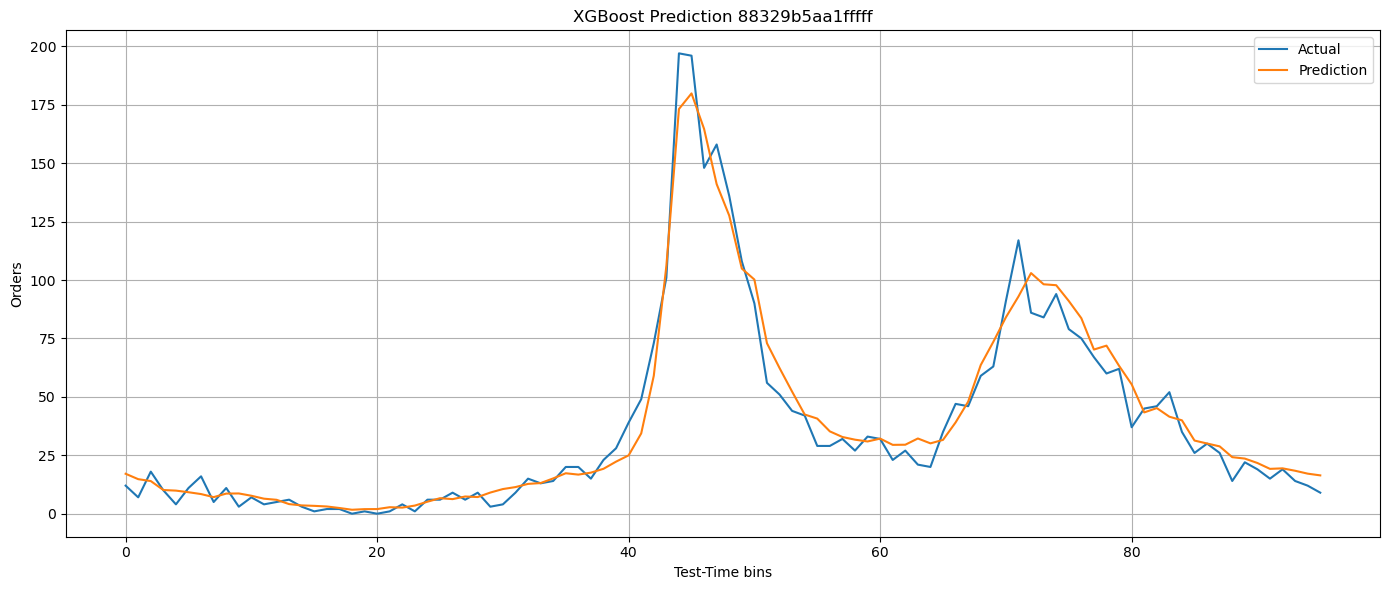

In [ ]:
example_area = "88329b5aa1fffff"  # change the area to observe
example_index = pivot_df.columns.get_loc(example_area)

plt.figure(figsize=(14, 6))
plt.plot(y_test[:, example_index], label='Actual')
plt.plot(predictions[:, example_index], label='Prediction')
plt.title(f'XGBoost Prediction {example_area}')
plt.xlabel('Test-Time bins')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
example_area = "88329b5aa1fffff"  # change the area to observe
example_index = pivot_df.columns.get_loc(example_area)
np.save('prognose_RF.npy', predictions[:, example_index])
